# JLab ML Challenge 3

Here's a notebook with my attempt at ML challenge 3. The challenge is to take an existing target image file that is predicted to be "bad" by a pretrained model and find the minimum change to the image that can cause the model to predict it is "good". This is different in that it does not require any model design or training. 

The first thing to do is simply plot the target image so we can see what we are working with. The plot on the left below is the target image that we wish to change. On the right is an exampel of an image that the model was trained to label "good".

In [1]:
from IPython.display import Image

input_fname='/home/davidl/work2/2019.12.17.MLChallenge3/MLChallenge3/TARGET_IMG.png'

<table><TR>
    <TD><center>"BAD" image we wish to minimally change</center><br><img src="TARGET_IMG.png" width=800></TD>
    <TD><center>Nominally "GOOD" image</center><br><img src="CDC_occupancy_041876.png" width=800></TD>
</TR></table>


## Load the pre-trained model

Here, I load the pretrained model. It is worth noting that if I do this with my customized virtual environment kernel,
it actually kills the whole session and I have to start a new one. If I instead use the deafult "Python 3" kernel
from the ai-notebook configuration, it works.

In [2]:
# Suppress a bunch of warnings when loading keras 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow import keras
from keras.models import load_model

MODEL_FILE = '/home/davidl/work2/2019.12.17.MLChallenge3/MLChallenge3/CDC_occupancy-1569856232_566866.h5'

print("Loading Model: " + MODEL_FILE)
model=load_model(MODEL_FILE)
print("Model Loaded")


Using TensorFlow backend.


Loading Model: /home/davidl/work2/2019.12.17.MLChallenge3/MLChallenge3/CDC_occupancy-1569856232_566866.h5



Model Loaded


## Run Test Images Through Model
 Here, I load up the image and run it through the model. I also do a couple of other tests with both an all white and all black images.
 The all white image is predicted with high confidence to be "NoData" which is not too suprising. Something a little suprising
 is that the model is 64% sure that the all black image is "Good" and 34% sure it is "Bad".
 
 Another very interesting thing I noticed is that if I forget to re-scale the image by 1/255, the model is perfectly confident that the image is good!

In [3]:
import numpy as np
from keras.preprocessing import image

image_list = []

# x = Target image
img_width  = 800
img_height = 600
img = image.load_img(input_fname, target_size=(img_height, img_width))
x_raw = image.img_to_array(img)
x = np.expand_dims(x_raw, axis=0)
image_list.append(('Original Target Image (not scaled)', x))

x_raw = image.img_to_array(img)
x_scaled = x_raw/255.0  # if we don't do this it is 100% positive it is good!
x = np.expand_dims(x_scaled, axis=0)
image_list.append(('Original Target Image (properly scaled)', x))

# y = all white
y = np.ones(shape=(img_height, img_width, 3))
y = np.expand_dims(y, axis=0)
image_list.append(('All white image', y))

# z = all black
z = np.zeros(shape=(img_height, img_width, 3))
z = np.expand_dims(z, axis=0)
image_list.append(('All black image', z))

# Run all images through model
myimages = [img for (s,img) in image_list]  # put image objects into list
images = np.vstack(myimages)
pred = model.predict(images)

# Print results
idx = 0
for (s,img) in image_list:
    print()
    print(s)
    print('------------')
    p = pred[idx]
    print('    Bad: ' + str(p[0]))
    print('   Good: ' + str(p[1]))
    print(' NoData: ' + str(p[2]))
    idx += 1

#model.summary()



Original Target Image (not scaled)
------------
    Bad: 0.0
   Good: 1.0
 NoData: 0.0

Original Target Image (properly scaled)
------------
    Bad: 0.99998045
   Good: 1.9141902e-05
 NoData: 3.0581936e-07

All white image
------------
    Bad: 1.7348873e-07
   Good: 5.4585363e-09
 NoData: 0.99999976

All black image
------------
    Bad: 0.35848024
   Good: 0.6415197
 NoData: 5.8907767e-17


## Accessing single Pixels

For the challenge, my first thought is to try and map out how much each pixel influces each of the prediction
values. I'll do this with a brute force numerical derivative by adjusting a single color on a single pixel
and run it through the model to see how it is affected. To do this though, I'll need to access individual pixel
values. Here, I choose a pixel in a region of the target image that is yellow (on the color scale) and print
out the RGB values for that and check that they seem like yellow (.i.e [1,1,0]).

Next, I change that color to pure red and plot the modified image so I can see that I really amy changing what I 
think I am. To actually make it easy to see, a block of 11x11 pixels are colored.

Yellow pixel: [0.9764706  0.9764706  0.05490196]


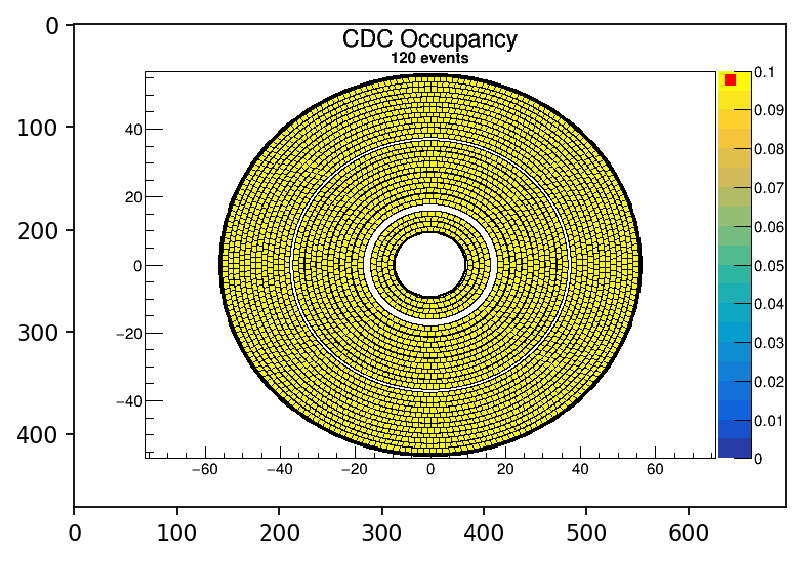

In [4]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi']= 160

# Load image with default pixel dimensions
img2 = image.load_img(input_fname)
xx = image.img_to_array(img2)
xx_scaled = xx/255.0 

X = 640
Y = 55
print('Yellow pixel: ' + str(xx_scaled[Y, X,:])) # n.b. X and Y backwards from what one would naturally expect here

x_new = np.copy( xx_scaled )

# Color a block with +-5 pixels around the target pixel as red
for ix in range(X-5, X+6):            
    for iy in range(Y-5, Y+6):            
        x_new[iy,ix,0] = 1.0
        x_new[iy,ix,1] = 0.0
        x_new[iy,ix,2] = 0.0

# Plot the modified image.
# I'm not really happy with how this plot looks. There is clearly some
# sampling being done and the aspect ratio looks different from the
# one at the top of the screen. The magic line setting the dpi to 150
# at the top at least brings it kind of close when using my monitor
# at home.
#fig = plt.figure(figsize = (img_width/100, img_height/100))
#fig = plt.figure(figsize = (img_width/100, img_height/100), dpi=100)
plt.imshow(x_new)

## Biggest output change by pixel color

At This point I want to generate a set of Jacobians of the image which is the first derivative of the classification output w.r.t. every input pixel's color. The original image is 696 x 472 pixels with 3 colors which means 985,536 derivatives.

One problem we have here is that the image is scaled as it is read in from the file since the model itself expects an 800x600 pixel image. This means changing a single pixel in the 696x472 image results in multiple pixels being changed so far as the model sees. Thus, if we work with modifying the original image, we need to resize it after every modification. This is what I decided to do here. Well, not "here". It turns out that is computationaly expensive so I had to run it on another computer (sciml1901) using a dedicated script. The script can be found in /home/davidl/work2/2019.12.17.MLChallenge4 (yes the name is wrong. It should have been MLChallenge3.) It took 12 hours to runs.

It is worth noting that another approach would be to resize the original image once and then find the minimal change to that which fools the model. Once that was done, we would need to find the change to the original 696x472 image file that produces the modified 800x600 image. This may not actually be possible. The big benefit with this approach though might be to avoid 2 million image resize operations which would save some time. At least in the beginning.

Below are the results of the calculation for the "good" classification only. The color values are taken by doing a linear mapping of the derivatives into the 0-255 range using the minimum and maximum derivative values. In this case, these were:

   good min: -5.39949E-9<br>
   good max:  6.96018E-9

<table><TR>
    <TD><center>RED  </center><br><img src="diff_goodR.png" width=400></TD>
    <TD><center>GREEN</center><br><img src="diff_goodG.png" width=400></TD>
    <TD><center>BLUE </center><br><img src="diff_goodB.png" width=400></TD>
</TR></table>

In the above images, the darker areas indicate negative derivatives while lighter colors are positive. The grey color indicate areas which have a smaller affect on the classifier. Below, we combine all of these images into a single one with all colors.

It is worth repeating that in these plots, the colors represent the derivatives where the values were linearly mapped to be from 0 to 255 with 0 corresponding to the smallest derivative (i.e. biggest negative number) and 255 corresponding to the largest derivative (i.e. biggest positive number). Mapping it that way does not make it clear which color corresponds to the derivatives being zero. It must be some shade of grey if the derivatives for all 3 colors are zero, but which shade is not necessarily obvious. See the following section for more.

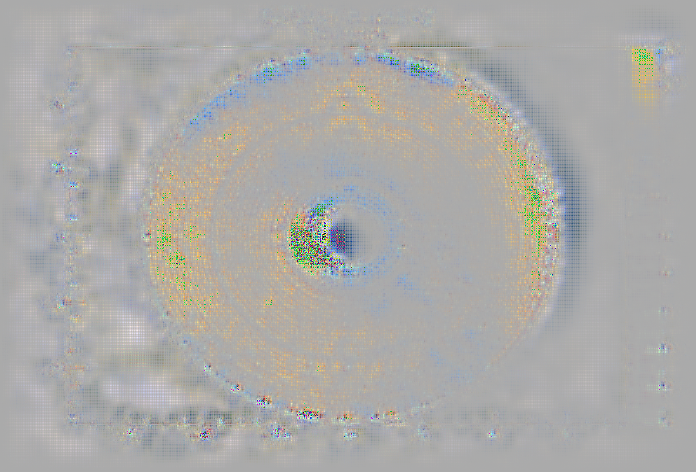

In [5]:
import PIL

aR = np.array( PIL.Image.open('diff_goodR.png'))
aG = np.array( PIL.Image.open('diff_goodG.png'))
aB = np.array( PIL.Image.open('diff_goodB.png'))
a_tot = aR + aG + aB
img_tot = PIL.Image.fromarray(a_tot)
display(img_tot)

## Calculating pixel changes

In this section we examine the derivatives a little more. We actually want to do this in units of the pixel values we need to change the image by in order to get the desired "good" classification. The derivatives were calculated in units of dgood/dcolor where dcolor is in units of pixel value (0-255). Below is the formula giving the good classifier dependance on the change in pixel color for every pixel in the image.

$$\Delta good = \alpha\sum_{i=1}^{328,512} \left(\frac{\partial good}{\partial r_{i}}\Delta r\right) + \left(\frac{\partial good}{\partial g_{i}}\Delta g\right) + \left(\frac{\partial good}{\partial b_{i}}\Delta b\right) $$

The value $\alpha$ is an overall scale factor that is calculated based on the desired value of $\Delta good$ and an assumption about the values of $\Delta r$, $\Delta g$, and $\Delta b$. Specifically, I assume the $\Delta$s themselves should be proportional to derivative for that color of that pixel. In other words, if the derivative is large, the $\Delta$ should be large and if the derivative is small, then the $\Delta$ should be small. E.g.

$$\Delta r \propto \frac{\partial good}{\partial r_{i}}$$

The propotionality constant is absorbed into the $\alpha$ value resulting in:

$$\Delta good = \alpha\sum_{i=1} \left(\frac{\partial good}{\partial r_{i}}\right)^{2} + \left(\frac{\partial good}{\partial g_{i}}\right)^{2} + \left(\frac{\partial good}{\partial b_{i}}\right)^{2} $$

or

$$ \alpha = \frac{\Delta good}{ \sum \left(\frac{\partial good}{\partial r_{i}}\right)^{2} + \left(\frac{\partial good}{\partial g_{i}}\right)^{2} + \left(\frac{\partial good}{\partial b_{i}}\right)^{2}} $$

Since for the target image the value of the good classifier is essentially zero, I set $\Delta good = 0.5$. Below are the values for the sum of squares as well as for $\alpha$ and the resulting minimum and maximum pixel value changes from that $\alpha$.

In [6]:
# Convert from pixel values into derivatives
dmin = -5.39949E-9
dmax = 6.96018E-9
dtot = a_tot/255.0*(dmax-dmin) + dmin

# Find sum of squares of all derivatives and calculate alpha from it
sum_squares = np.sum(np.square(dtot))

# Calculate alpha from target change to "good" of 0.5
alpha = 0.5/sum_squares

# Calculate change of every pixel
delta_pixels = dtot*alpha

print('      sum_squares: %g' % sum_squares)
print('            alpha: %g' % alpha)
print('max. pixel change: ' + str(delta_pixels.max()))
print('min. pixel change: ' + str(delta_pixels.min()))


      sum_squares: 8.46647e-12
            alpha: 5.90565e+10
max. pixel change: 411.04375410915463
min. pixel change: -318.87489114862535


Below are 2 plots showing only the positive pixel changes and only the negative changes. Areas that are black in both indicate pixels that don't really change the good classification. What is interesting here is that there is very little black in the positive derivative plot. ***This means most pixels have some affect on the good classifier.***

In [7]:

# Display delta image. Since values can be positive or negative, display positives and negatives separately
img_delta_pos = PIL.Image.fromarray(np.clip(delta_pixels, 0., 255.).astype(np.uint8))
img_delta_neg = PIL.Image.fromarray(np.clip(-delta_pixels, 0., 255.).astype(np.uint8))
img_delta_pos.save('delta_pos.png')
img_delta_neg.save('delta_neg.png')

<table><TR>
    <TD><center>Positive derivatives</center><br><img src="delta_pos.png" width=500></TD>
    <TD><center>Negative derivatives</center><br><img src="delta_neg.png" width=500></TD>
</TR></table>


## Modified image

Here I finally calculate the modified image based on the $\Delta$s calculated above. A couple of things to note:

1. You may have noticed above that the minimum and maximum pixel changes had magnitudes greater than 255. This means the pixel values ***CANNOT*** change as much as we would want to get the desired change to the good classifier since the values must be clipped to be in the 0-255 range.

2. The overall effect on the image seems to make it look faded as opposed to more blue as the good images used to train the model.

In reference to 1.: You'll notice the term delta_pixels\*1.0. The 1.0 mulitplier was put in so I could play with it manually to see if increasing the overall magnitude of the change in pixels would bring up the good classification value. The short story is that it I was unable to find a value that resulted in the good classification being the largest. As the fudge factor was increased, the "No Data" classification rose quicker than "good".

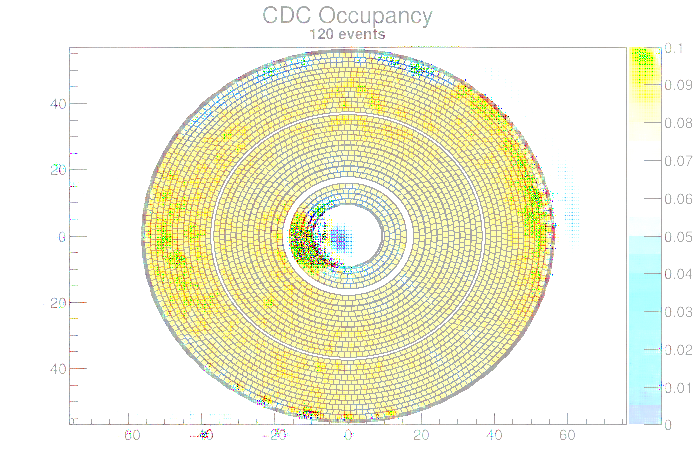

In [8]:
# Create modified image

img_orig = PIL.Image.open(input_fname)
a_modified = np.clip(np.array(img_orig).astype(np.float64) + delta_pixels*1.0, 0., 255.)
img_modified = PIL.Image.fromarray(a_modified.astype(np.uint8))
display(img_modified)
img_modified.save('modified.png')

In [9]:
# Load modified image file and infer
img_width  = 800
img_height = 600
img = image.load_img('modified.png', target_size=(img_height, img_width))
x_raw = image.img_to_array(img)/255.0
x = np.expand_dims(x_raw, axis=0)
pred = model.predict( np.vstack([x]) )
print('    Bad: ' + str(pred[0,0]))
print('   Good: ' + str(pred[0,1]))
print(' NoData: ' + str(pred[0,2]))


    Bad: 0.99153733
   Good: 0.008269495
 NoData: 0.00019315221


## Turn up the Brightness

While working on this, mistakes were often made and corrected. I noticed while doing this though that if the image was generally lighter, then the good classification was sometimes much better. In this section, I simply add a value to all pixel values and then clip them to 255. I played around with this manually and found that adding 129.1 to every pixel value did result in an image where the good classifier was the highest. Larger values increased the good. In fact increasing it to 139.1 resulted in the model giving a >0.98 value for good. If this brightness value was increased further to a value of 169.1, the "no data" classification became dominate at >0.99.

Following up on this, I tried just increasing the blue without changing the red or green. This did actually improve the good classifier. A little more playing showed that adjusting the green also had an affect, but to a lesser extent. In the end, I could achieve >0.9 for the good classifier in various ways. The cell below plots a few.

In [12]:
# Try simply turning up brightness by adding constant to all colors of all pixels
img = image.load_img(input_fname)
x_raw = image.img_to_array(img)

# This is a little bit of a dance since I want to modify the original
# 696x472 image, but need to resize it to 800x600 for the model prediction.
brightness = 139.1
x_raw_rgb = np.clip(x_raw+brightness,0., 255.0)
img_modified = PIL.Image.fromarray(x_raw_rgb.astype(np.uint8))
img_modified.save('modified_bright.png')     # 696 x 472
img_modified = img_modified.resize((img_width,img_height))  # 800 x 600
x = np.expand_dims(image.img_to_array(img_modified)/255.0, axis=0)
pred1 = model.predict( np.vstack([x]) )

# Adjust only Blue
brightness = 190
x_raw_b = np.clip(x_raw+(0,0,brightness),0., 255.0)
img_modified = PIL.Image.fromarray(x_raw_b.astype(np.uint8))
img_modified.save('modified_B.png')     # 696 x 472
img_modified = img_modified.resize((img_width,img_height))  # 800 x 600
x = np.expand_dims(image.img_to_array(img_modified)/255.0, axis=0)
pred2 = model.predict( np.vstack([x]) )

# Adjust only Green and Blue and by lesser amount
brightness = 100
x_raw_gb = np.clip(x_raw+(0,brightness,brightness),0., 255.0)
img_modified = PIL.Image.fromarray(x_raw_gb.astype(np.uint8))
img_modified.save('modified_GB.png')     # 696 x 472
img_modified = img_modified.resize((img_width,img_height))  # 800 x 600
x = np.expand_dims(image.img_to_array(img_modified)/255.0, axis=0)
pred3 = model.predict( np.vstack([x]) )

# Calculate pixel difference for all modified images
pdiff_rgb = np.sum( x_raw_rgb - x_raw )/(696.*472.)/3.
pdiff_b   = np.sum( x_raw_b   - x_raw )/(696.*472.)/3.
pdiff_gb  = np.sum( x_raw_gb  - x_raw )/(696.*472.)/3.

mess ='''
<table>
<TR>
    <TD>
    Brighten all colors by 139.1
    </TD>
    <TD>
Bad: ''' + str(pred1[0,0]) + '''<br>
Good: ''' + str(pred1[0,1]) + '''<br>
NoData: ''' + str(pred1[0,2]) + '''<br>
    </TD>
    <TD>
    Brighten Blue by 190
    </TD>
    <TD>
Bad: ''' + str(pred2[0,0]) + '''<br>
Good: ''' + str(pred2[0,1]) + '''<br>
NoData: ''' + str(pred2[0,2]) + '''<br>
    </TD>
    <TD>
    Brighten Green and Blue by 100
    </TD>
    <TD>
Bad: ''' + str(pred3[0,0]) + '''<br>
Good: ''' + str(pred3[0,1]) + '''<br>
NoData: ''' + str(pred3[0,2]) + '''<br>
    </TD>
</TR>
<TR>
    <TD colspan="2"><img src="modified_bright.png" width=400></TD>
    <TD colspan="2"><img src="modified_B.png" width=400></TD>
    <TD colspan="2"><img src="modified_GB.png" width=400></TD>
</TR>
<TR>
    <TD colspan="2">avg. pixel_diff = ''' + str(pdiff_rgb) + '''</TD>
    <TD colspan="2">avg. pixel_diff = ''' + str(pdiff_b)   + '''</TD>
    <TD colspan="2">avg. pixel_diff = ''' + str(pdiff_gb)  + '''</TD>
</TR>
</table>
'''

from IPython.display import HTML
display(HTML(mess))

## Conclusions

The primary attempt to tweak the image using derivatives failed to trick the model. This may not be too surprising since that assumed a linear relation between each pixel color and the output with absolutely no correlation between pixels. The correlations may actually be very important for this, but to generate a correlation matrix using the numerical derivative technique used here is computationally too expensive.

The most interesting take away may be how easy it is to dial up the classification you want by just adjusting the brightness of the image. Granted, many pixels would to be changed by >100 units to get a large confidence of "good". However, the resulting image doesn't look anything like the images labeled "good" from the training sample. The model seems to be looking mostly at the blue and green with little concern for the red. This is interesting since to the human eye, adding a lot of red will make a completely different color.

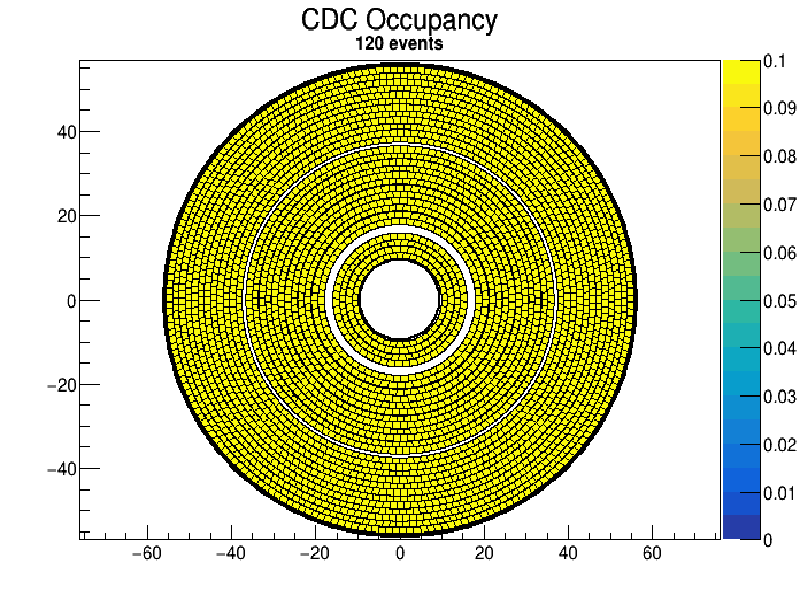

In [11]:
img = image.load_img(input_fname, target_size=(img_height, img_width))
display(img)